
# BanglaBERT **Fusion** Model (Text + Engagement + Channel)

In [ ]:

import os, math, json, random, warnings
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

warnings.filterwarnings('ignore')

from google.colab import drive
USE_DRIVE = False   # set False if you don’t want Drive
drive.mount('/content/drive')
if USE_DRIVE:
    SAVE_DIR = "/content/drive/MyDrive/Dataset/colab_runs"
else:
    SAVE_DIR = "/content/baitbuster_runs"

import os; os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving to:", SAVE_DIR)


DATA_PATH  = "/content/drive/MyDrive/Dataset/BaitBuster-Bangla A Comprehensive Dataset for Clickbait Detection in Bangla with Multi-Feature and Multi-Modal Analysis/BaitBuster-Bangla_253070_18c_HL10k_AIL.csv"      # <-- set your dataset path
MODEL_NAME = 'csebuetnlp/banglabert'           # or 'sagorsarker/bangla-bert-base'
MAX_LEN    = 160
BATCH_SIZE = 16
EPOCHS     = 5
LR         = 2e-5
WEIGHT_DECAY = 0.01
DROPOUT    = 0.2
SEED       = 42
DEVICE     = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

print('Device:', DEVICE)


Mounted at /content/drive
Saving to: /content/baitbuster_runs
Device: cuda


In [ ]:

def load_df(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f'File not found: {path}'
    if path.endswith('.csv') or path.endswith('.csv.gz'):
        return pd.read_csv(path)
    elif path.endswith('.parquet'):
        return pd.read_parquet(path)
    elif path.endswith('.xlsx'):
        return pd.read_excel(path)
    else:
        raise ValueError('Unsupported extension')

df = load_df(DATA_PATH)
print('Raw shape:', df.shape)
df.head(2)


Raw shape: (253173, 18)


,channel_id,channel_name,channel_url,video_id,publishedAt,title,title_debiased,description,description_debiased,url,viewCount,commentCount,likeCount,dislikeCount,thumbnail,auto_labeled,human_labeled,ai_labeled
0,UCw4gfo5oaGPkHwarenuewAg,Ruposhi Bangla Tv,https://www.youtube.com/c/RuposhiBanglaTvtopvi...,J9xErXLh3bo,2021-08-17T08:59:13Z,এইমাত্র! মসজিদে নামাজরত অবস্থায় তিন বৃদ্ধকে পি...,এইমাত্র! মসজিদে নামাজরত অবস্থায় তিন বৃদ্ধকে পি...,ভিডিওটি ভাল লাগলে লাইক দিন \r\nও সবাইকে দেখার ...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,https://www.youtube.com/watch?v=J9xErXLh3bo,12743,45.0,536,35.0,https://i.ytimg.com/vi/J9xErXLh3bo/default.jpg,Clickbait,Clickbait,Clickbait
1,UCw4gfo5oaGPkHwarenuewAg,Ruposhi Bangla Tv,https://www.youtube.com/c/RuposhiBanglaTvtopvi...,HPa6mRwjUg8,2021-08-17T04:19:08Z,"১০ বছরের সন্তান ফেলে আ,লীগ নেতার সাথে পালিয়ে গ...","১০ বছরের সন্তান ফেলে আ,লীগ নেতার সাথে পালিয়ে গ...",ভিডিওটি ভাল লাগলে লাইক দিন \r\nও সবাইকে দেখার ...,ভিডিওটি লাগলে লাইক দিন ও সবাইকে দেখার সুযোগ কর...,https://www.youtube.com/watch?v=HPa6mRwjUg8,22440,10.0,362,20.0,https://i.ytimg.com/vi/HPa6mRwjUg8/default.jpg,Clickbait,Clickbait,Clickbait


In [ ]:

candidate_targets = ['human_labeled','ai_labeled','auto_labeled']
target_col = next((c for c in candidate_targets if c in df.columns), None)
assert target_col, 'No target among human_labeled/ai_labeled/auto_labeled'

leak_cols = [c for c in ['auto_labeled','human_labeled','ai_labeled','title_debiased','description_debiased'] if c in df.columns]
if 'title' not in df.columns: df['title'] = ''
if 'description' not in df.columns: df['description'] = ''

engagement_cols = [c for c in ['viewCount','commentCount','likeCount','dislikeCount'] if c in df.columns]
if 'channel_id' not in df.columns: df['channel_id'] = '__nogroup__'

if 'publishedAt' in df.columns:
    dt = pd.to_datetime(df['publishedAt'], errors='coerce')
    df['pub_hour'] = dt.dt.hour
    df['pub_wday'] = dt.dt.weekday
else:
    df['pub_hour'] = np.nan
    df['pub_wday'] = np.nan

df['text'] = (df['title'].fillna('') + ' [SEP] ' + df['description'].fillna('')).str.strip()

def to_binary(s: pd.Series) -> pd.Series:
    if s.dtype == 'O':
        t = s.astype(str).str.lower().str.strip()
        mapping = {'clickbait':1,'click bait':1,'non-clickbait':0,'non clickbait':0,'yes':1,'no':0,'true':1,'false':0,'1':1,'0':0,'bait':1,'not-bait':0}
        y = t.map(mapping)
        m = y.isna()
        if m.any(): y.loc[m] = pd.to_numeric(t[m], errors='coerce')
        y = y.astype(float)
    else:
        y = pd.to_numeric(s, errors='coerce')
    return y.round().astype(int)

df = df[~df[target_col].isna()].copy()
y_all = to_binary(df[target_col])
df   = df.loc[~y_all.isna()].copy()
y_all = y_all.loc[df.index].astype(int)

groups = df['channel_id'].astype(str)
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
tr_idx, va_idx = next(gss.split(df, y_all, groups=groups))

train_df = df.iloc[tr_idx].reset_index(drop=True)
valid_df = df.iloc[va_idx].reset_index(drop=True)
y_train  = y_all.iloc[tr_idx].reset_index(drop=True)
y_valid  = y_all.iloc[va_idx].reset_index(drop=True)

print('Train:', train_df.shape, ' Valid:', valid_df.shape)


Train: (6132, 21)  Valid: (3868, 21)


In [ ]:

num_cols = [c for c in engagement_cols + ['pub_hour','pub_wday'] if c in train_df.columns]

def make_num_feats(df_part: pd.DataFrame) -> np.ndarray:
    if not num_cols:
        return np.zeros((len(df_part), 0), dtype=np.float32)
    X = df_part[num_cols].copy()
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors='coerce')
    for c in engagement_cols:
        if c in X.columns: X[c] = np.log1p(X[c])
    X = X.fillna(0.0)
    return X.values.astype(np.float32)

scaler = StandardScaler()
Xnum_train = make_num_feats(train_df)
Xnum_valid = make_num_feats(valid_df)
if Xnum_train.shape[1] > 0:
    scaler.fit(Xnum_train)
    Xnum_train = scaler.transform(Xnum_train).astype(np.float32)
    Xnum_valid = scaler.transform(Xnum_valid).astype(np.float32)
num_dim = Xnum_train.shape[1]

all_channels = df['channel_id'].astype(str).fillna('__unk__').unique().tolist()
ch2idx = {ch:i for i,ch in enumerate(sorted(all_channels))}
chan_train = train_df['channel_id'].astype(str).map(ch2idx).values.astype('int64')
chan_valid = valid_df['channel_id'].astype(str).map(ch2idx).values.astype('int64')
vocab_size = len(ch2idx)

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:

class FusionDataset(Dataset):
    def __init__(self, df_part, y, Xnum, chan_ids, tokenizer, max_len):
        self.texts = df_part['text'].tolist()
        self.labels = y.values.astype(np.float32)
        self.Xnum   = Xnum
        self.chan   = chan_ids
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        t = self.tokenizer(self.texts[idx], max_length=self.max_len, padding='max_length', truncation=True, return_tensors='pt')
        item = {k: v.squeeze(0) for k,v in t.items()}
        item['num_feats'] = torch.tensor(self.Xnum[idx], dtype=torch.float32) if self.Xnum.shape[1] > 0 else torch.zeros(0, dtype=torch.float32)
        item['chan_id']   = torch.tensor(self.chan[idx], dtype=torch.long)
        item['label']     = torch.tensor(self.labels[idx], dtype=torch.float32)
        return item

train_ds = FusionDataset(train_df, y_train, Xnum_train, chan_train, tokenizer, MAX_LEN)
valid_ds = FusionDataset(valid_df, y_valid, Xnum_valid, chan_valid, tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(valid_ds)


(6132, 3868)

In [ ]:

class BanglaBertFusion(nn.Module):
    def __init__(self, model_name, num_dim, chan_vocab, chan_emb_dim=32, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hid = self.bert.config.hidden_size
        self.use_num = num_dim > 0
        if self.use_num:
            proj_dim = min(64, max(8, num_dim))
            self.num_proj = nn.Sequential(
                nn.LayerNorm(num_dim),
                nn.Linear(num_dim, proj_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
            )
        else:
            proj_dim = 0
            self.num_proj = None
        self.chan_emb = nn.Embedding(chan_vocab, 32)
        fused_dim = hid + 32 + (proj_dim if self.use_num else 0)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.Linear(fused_dim, 256), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(256, 64), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, input_ids, attention_mask, token_type_ids=None, num_feats=None, chan_id=None):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls = out.last_hidden_state[:,0,:]
        ch  = self.chan_emb(chan_id)
        if self.use_num and num_feats is not None and num_feats.nelement()>0:
            nx  = self.num_proj(num_feats)
            x = torch.cat([cls, ch, nx], dim=1)
        else:
            x = torch.cat([cls, ch], dim=1)
        x = self.dropout(x)
        return self.head(x).squeeze(1)

model = BanglaBertFusion(MODEL_NAME, num_dim=num_dim, chan_vocab=vocab_size, dropout=DROPOUT).to(DEVICE)


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:

pos = int((y_train==1).sum()); neg = int((y_train==0).sum())
pos_weight = torch.tensor([neg/max(1,pos)], dtype=torch.float32, device=DEVICE) if pos>0 and neg>0 else None

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

steps = len(train_loader)*EPOCHS
warm  = int(0.1*steps)
scheduler = get_linear_schedule_with_warmup(optimizer, warm, steps)


In [ ]:

EPOCHS     = 10
def pass_epoch(loader, train=False):
    model.train(train)
    total_loss, total_correct, total_n = 0.0, 0, 0
    Y, P, H = [], [], []
    for b in loader:
        ids = b['input_ids'].to(DEVICE); attn = b['attention_mask'].to(DEVICE)
        tok = b.get('token_type_ids'); tok = tok.to(DEVICE) if tok is not None else None
        num = b['num_feats'].to(DEVICE) if b['num_feats'].ndim==2 else None
        ch  = b['chan_id'].to(DEVICE)
        y   = b['label'].to(DEVICE)

        with torch.set_grad_enabled(train):
            logit = model(ids, attn, tok, num, ch)
            loss  = criterion(logit, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

        prob = torch.sigmoid(logit).detach().cpu().numpy().ravel()
        hyp  = (prob>=0.5).astype(int)
        yy   = y.detach().cpu().numpy().astype(int).ravel()

        total_loss += loss.item()*len(yy)
        total_correct += (hyp==yy).sum()
        total_n += len(yy)

        Y.extend(yy.tolist()); P.extend(prob.tolist()); H.extend(hyp.tolist())

    return total_loss/max(1,total_n), total_correct/max(1,total_n), np.array(Y), np.array(P), np.array(H)

hist = {'tr_loss':[], 'va_loss':[], 'tr_acc':[], 'va_acc':[], 'va_roc':[], 'va_pr':[]}
best, wait, patience, best_state = -1.0, 0, 2, None

for ep in range(1, EPOCHS+1):
    tl, ta, _, _, _ = pass_epoch(train_loader, True)
    vl, va, Y, P, H = pass_epoch(valid_loader, False)
    try: roc = roc_auc_score(Y,P)
    except: roc = float('nan')
    try: pr  = average_precision_score(Y,P)
    except: pr = float('nan')
    hist['tr_loss'].append(tl); hist['va_loss'].append(vl)
    hist['tr_acc'].append(ta);  hist['va_acc'].append(va)
    hist['va_roc'].append(roc); hist['va_pr'].append(pr)
    print(f'E{ep:02d} | tr {tl:.4f}/{ta:.3f}  va {vl:.4f}/{va:.3f}  ROC {roc:.4f} PR {pr:.4f}')
    score = 0 if math.isnan(roc) else roc
    if score>best: best=score; best_state={k:v.cpu().clone() for k,v in model.state_dict().items()}; wait=0
    else:
        wait+=1
        if wait>=patience:
            print('Early stopping.'); break

if best_state is not None:
    model.load_state_dict(best_state)


E01 | tr 0.0114/0.998  va 10.9310/0.196  ROC 0.4934 PR 0.9853
E02 | tr 0.0111/0.998  va 10.9310/0.196  ROC 0.4934 PR 0.9853
E03 | tr 0.0113/0.998  va 10.9310/0.196  ROC 0.4934 PR 0.9853
Early stopping.


=== Classification Report (Validation) ===
              precision    recall  f1-score   support

           0     0.0090    0.5385    0.0177        52
           1     0.9682    0.1916    0.3198      3816

    accuracy                         0.1962      3868
   macro avg     0.4886    0.3650    0.1688      3868
weighted avg     0.9553    0.1962    0.3158      3868

ROC-AUC: 0.4934 | PR-AUC: 0.9853
Confusion Matrix:
 [[  28   24]
 [3085  731]]


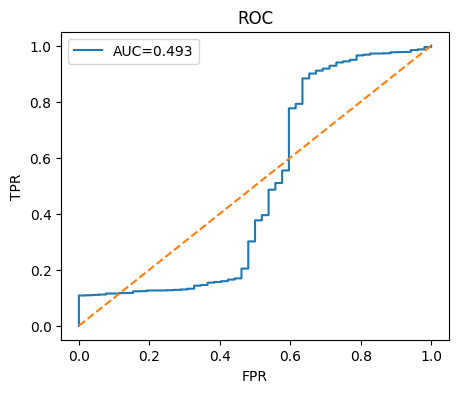

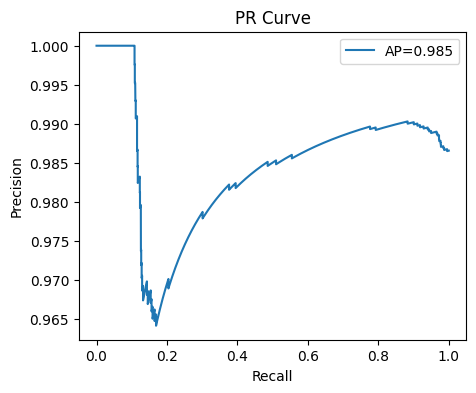

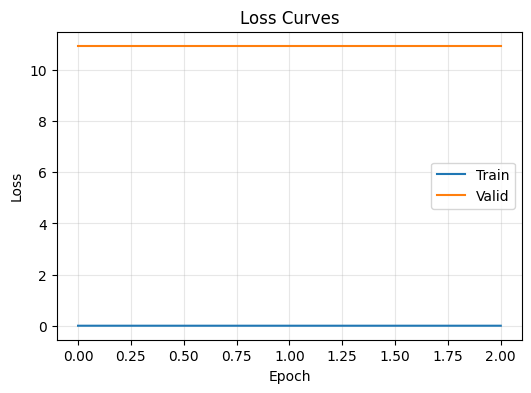

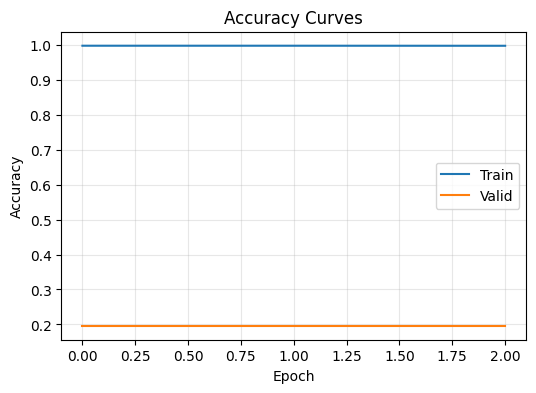

In [ ]:

model.eval()
_, _, Y, P, H = pass_epoch(valid_loader, False)

print('=== Classification Report (Validation) ===')
print(classification_report(Y, H, digits=4))

try: roc = roc_auc_score(Y,P)
except: roc=float('nan')
try: pr  = average_precision_score(Y,P)
except: pr=float('nan')
print(f'ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y,H); print('Confusion Matrix:\n', cm)

from sklearn.metrics import roc_curve, precision_recall_curve
fpr,tpr,_ = roc_curve(Y,P); prec,rec,_ = precision_recall_curve(Y,P)

plt.figure(figsize=(5,4)); plt.plot(fpr,tpr,label=f'AUC={roc:.3f}'); plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.show()

plt.figure(figsize=(5,4)); plt.plot(rec,prec,label=f'AP={pr:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Curve'); plt.legend(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist['tr_loss'],label='Train'); plt.plot(hist['va_loss'],label='Valid')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curves'); plt.legend(); plt.grid(True,alpha=0.3); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist['tr_acc'],label='Train'); plt.plot(hist['va_acc'],label='Valid')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curves'); plt.legend(); plt.grid(True,alpha=0.3); plt.show()
